# Model Creation and FEMAG Invocation

There are several ways to run FEMAG with femagtools: either using an existing FSL script or
 - by using a parametrized stator and magnet model or a user specified FSL fragment
 - by using an existing I7/A7 model file
 
optionally in combination with one of the 7 FE simulation functions: cogg_calc, pm_rel_sim_fast, pm_sym_loss, mult_cal_fast, torq_calc, ld_lq_fast, psd_psq_fast.

In [1]:
import femagtools

Create the FSL command by referencing a model name:

In [2]:
femagtools.create_fsl('PM_270_L8')

['  exit_on_error=true',
 '  exit_on_end=true',
 '  verbosity=2',
 '',
 "model = 'PM_270_L8'",
 'load_model(model)',
 '',
 '',
 '  global_unit(mm)',
 '  pickdist(0.001)',
 '  cosys(polar)',
 '',
 'm.hc_min          =        95.000 --   Limit demagnetisa > 0:[%]Hc,<0:[kA/m]   ',
 'm.con_hdcopy      =         0.000 --   Hc-copy:Name:auto:0,intact:1, none:-1   ',
 'm.b_max           =         2.400 --   Max Induction [T] in colorgradation     ',
 'm.b_min           =         0.000 --   Move inside: 0 , Move outside: > 0      ',
 'm.calc_fe_loss    =         1.000 --   Calc. FE-Loss:0:no, 1:yes, 2:m-output   ',
 'm.eval_force      =         0.000 --   Eval. force density > 0, no <= 0        ',
 'm.allow_draw      =         1.000 --   Draw Graphics :> 0: yes, 0:  no         ',
 'm.fline_dens      =         4.000 --   F-Lines: 1: small, 2: medium, 3:thick   ',
 'm.num_flines      =        20.000 --   Number of Field-lines:      < 100 > 2   ',
 'm.name_bch_log    =         0.000 --   Name bch

This produces a list of FSL commands which can be written to a file:

In [3]:
with open('femag.fsl', 'w') as f:
    f.write('\n'.join(femagtools.create_fsl('PM_270_L8')))

Note: The explicit creation of an FSL file is often not necessary. 

The FSL commands to build a FEMAG model can be generated from parameterized stator and magnet models. This is done by setting up a dict variable that contains a general set of parameters together with the stator, magnet and winding dicts:

In [4]:
machine = {
    "name": "PM 270 L8",
    "desc": "PM Motor 270mm 8 poles VMAGN",
    "poles": 8,
    "outer_diam": 0.26924,
    "bore_diam": 0.16192,
    "inner_diam": 0.11064,
    "airgap": 0.00075,
    "lfe": 0.08356,
    "stator": {
        "num_slots": 48,
        "mcvkey_yoke": 'M270-35A',
        "statorRotor3": {
            "slot_height": 0.0335,
            "slot_h1": 0.001,
            "slot_h2": 0.0,
            "slot_width": 0.00193,
            "slot_r1": 0.0001,
            "slot_r2": 0.00282,
            "wedge_width1": 0.00295,
            "wedge_width2": 0.0,
            "middle_line": 0.0,
            "tooth_width": 0.0,
            "slot_top_sh": 0.0}
    },
    "magnet": {
        "mcvkey_yoke": 'M270-35A',
        "nodedist": 4,
        "magnetIronV": {
            "magn_angle": 145.0,
            "magn_height": 0.00648,
            "magn_width": 0.018,
            "condshaft_r": 0.05532,
            "magn_num": 1.0,
            "air_triangle": 1,
            "iron_hs": 0.0,
            "gap_ma_iron": 0.0002,
            "iron_height": 0.00261,
            "magn_rem": 1.2,
            "iron_shape": 0.0802
        }
    },
    "windings": {
        "num_phases": 3,
        "num_layers": 1,
        "num_wires": 9,
        "coil_span": 6.0,
        "cufilfact": 0.4,
        "culength": 1.4,
        "slot_indul": 0.5e-3
    }
}

Using this model description it is possible to create the FSL file by a set of pre-defined templates. To do so we first chose a working directory and set the directory of the MC/MCV files using the parameter 'magnetizingCurves':

In [5]:
import os
workdir = os.path.join(os.path.expanduser('~'), 'femag')
fslfile = 'femag.fsl'
with open(os.path.join(workdir, fslfile), 'w') as f:
    f.write('\n'.join(femagtools.create_fsl(machine)))
femag = femagtools.femag.Femag(workdir, magnetizingCurves='.')
femag.run(fslfile, options=['-g'])

/home/tar/femag/femag.out
(0lqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqk(B
(0x(B **** FSL ****                   FEMAG   Version 8.4.x (Rev. 3235) (0x(B
(0x(B Script Language Interpreter                                       (0x(B
(0mqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqj(B
Start: Wed Nov  7 11:39:31 2018

FSL...exe "femag.fsl"
New model "PM_270_L8", ""
Global unit of length is 0.001 m
Pick distance is 0.001
Set coordinate system to polar
Preprocessing CAD model FE-contr-data
Preprocessing CAD model basic_modpar
Preprocessing CAD model CU-Losses-1
Preprocessing CAD model CU-Losses-2
Preprocessing CAD model STATOR_3
Postprocessing CAD model: nodedistance => ndst
Preprocessing CAD model Gen_winding
Preprocessing CAD model gen_pocfile
Preprocessing CAD model Magnet Iron V
Preprocessing CAD model connect_models
Save model and continue
FSL...halt

Stop: Wed Nov  7 11:39:36 2018
Elapsed time:      5s



To invoke a FE calculation an additional dict must be setup:

In [6]:
simulation = {
    "angl_i_up": -30.0,
    "calculationMode": "pm_sym_fast",
    "num_move_steps": 0,
    "wind_temp": 60.0,
    "magn_temp": 60.0,
    "current": 150.0,
    "speed": 50.0,
    "airgap_induc": True
}

If we want to receive some feedback a logger would be useful: 

In [7]:
import logging
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(message)s')

Now we can invoke FEMAG without creating an FSL file. The Femag object knows how to handle this:

In [8]:
r = femag(machine,
          simulation, options=['-g'])

2018-11-07 11:39:36,345 search file M270-35A.MCV in /home/tar/Documents/semafor/pres/fat-2017/femagtools-workshop
2018-11-07 11:39:36,346 search file M270-35A.MCV in /home/tar/Documents/semafor/pres/fat-2017/femagtools-workshop
2018-11-07 11:39:36,348 MC Version 0
2018-11-07 11:39:36,355 Write File /home/tar/femag/M270-35A.MCV, binary format 1
2018-11-07 11:39:36,360 create new model and simulation
2018-11-07 11:39:36,366 use template new_model.mako
2018-11-07 11:39:36,394 use template cu_losses.mako
2018-11-07 11:39:36,407 use template statorRotor3.mako
2018-11-07 11:39:36,418 use template gen_winding.mako
2018-11-07 11:39:36,427 use template magnetIronV.mako
2018-11-07 11:39:36,429 use template airgapinduc.mako
2018-11-07 11:39:36,433 use template cu_losses.mako
2018-11-07 11:39:36,448 use template pm_sym_fast.mako
2018-11-07 11:39:36,463 use template plots.mako
2018-11-07 11:39:36,467 invoking xfemag64 -g femag.fsl
2018-11-07 11:41:02,067 xfemag64 exited with returncode 0 (num errs=

/home/tar/femag/femag.out
(0lqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqk(B
(0x(B **** FSL ****                   FEMAG   Version 8.4.x (Rev. 3235) (0x(B
(0x(B Script Language Interpreter                                       (0x(B
(0mqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqj(B
Start: Wed Nov  7 11:39:36 2018

FSL...exe "femag.fsl"
New model "PM_270_L8", ""
Global unit of length is 0.001 m
Pick distance is 0.001
Set coordinate system to polar
Preprocessing CAD model FE-contr-data
Preprocessing CAD model basic_modpar
Preprocessing CAD model CU-Losses-1
Preprocessing CAD model CU-Losses-2
Preprocessing CAD model STATOR_3
Postprocessing CAD model: nodedistance => ndst
Preprocessing CAD model Gen_winding
Preprocessing CAD model gen_pocfile
Preprocessing CAD model Magnet Iron V
Preprocessing CAD model connect_models
Preprocessing CAD model CU-Losses-1
Preprocessing CAD model CU-Losses-2
Setting device data 'cond_temp' to 60 and 

After a calculation has finished we can examine all the BCH values which are included in the result 'r'. For example the torque:

In [9]:
r.machine['torque']

301.7929

If we had set the parameter 'airgap_induc' to True we can read the produced airgap values:

In [10]:
airgap = femag.read_airgap_induction()

2018-11-07 11:41:02,121 Read BCH /home/tar/femag/PM_270_L8_070.BATCH
2018-11-07 11:41:02,136 /home/tar/femag/bag.dat: Period 90.400000 max phi 90.400000 B amp 1.549399


and create a nice plot including the base harmonic:

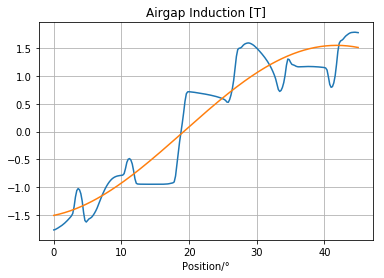

In [11]:
import matplotlib.pylab as plt
import femagtools.plot
femagtools.plot.airgap(airgap)
plt.show()

We can even create a graphical report of the results:

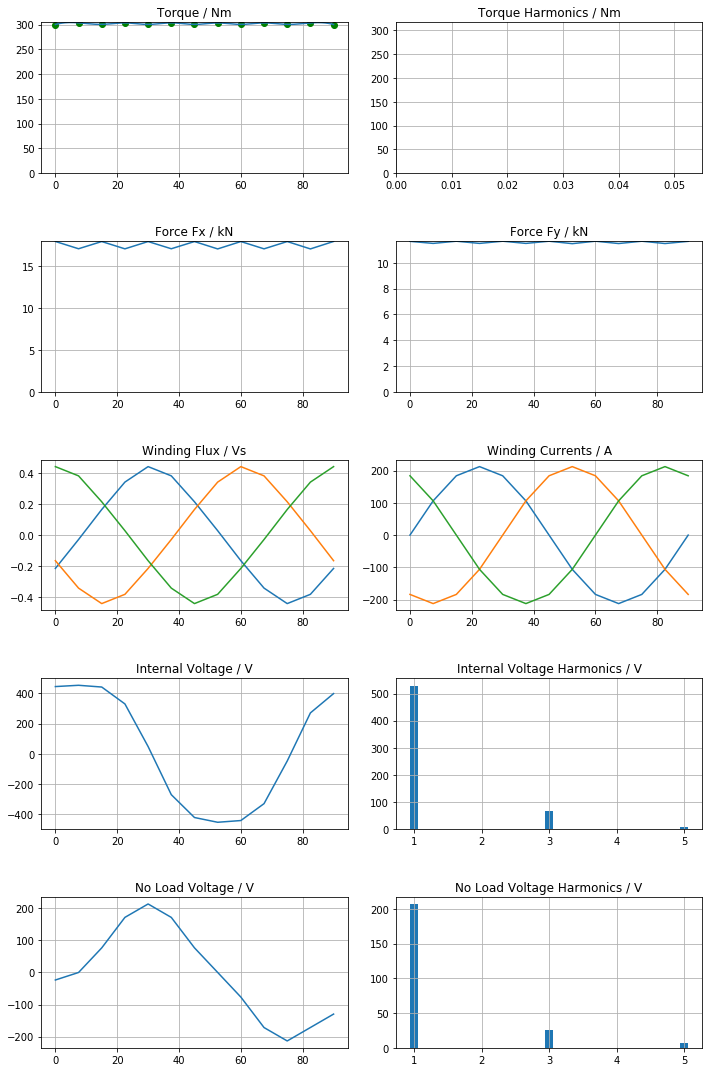

In [12]:
femagtools.plot.pmrelsim(r)
plt.show()

## Model creation with user specific model

A user specific model is based on a FSL file that includes the necessary nodechain and material definitions. This script can then be included in the magnet dict of the machine. In the following example the file is named 'spokefml.fsl':

In [13]:
machine['magnet'] = dict(
        mcvkey_yoke='M270-35A',
        spokefml=dict(
            magn_height=0.008,
            shaft_diam=0.01,
            slot_width=0.004,
            magn_width=0.022
        )
)

The FSL fragment should make use of the globally defined variables as described in the femagtools documentation.

In [14]:
fslfile = 'femag.fsl'
with open(os.path.join(workdir, fslfile), 'w') as f:
    f.write('\n'.join(femagtools.create_fsl(machine)))
femag.run(fslfile, options=['-g'])

2018-11-07 11:41:03,796 use template new_model.mako
2018-11-07 11:41:03,816 use template cu_losses.mako
2018-11-07 11:41:03,828 use template statorRotor3.mako
2018-11-07 11:41:03,833 use template gen_winding.mako
2018-11-07 11:41:03,842 use FSL spokefml.fsl
2018-11-07 11:41:03,844 invoking xfemag64 -g femag.fsl
2018-11-07 11:41:08,703 xfemag64 exited with returncode 0 (num errs=0)


/home/tar/femag/femag.out
(0lqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqk(B
(0x(B **** FSL ****                   FEMAG   Version 8.4.x (Rev. 3235) (0x(B
(0x(B Script Language Interpreter                                       (0x(B
(0mqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqj(B
Start: Wed Nov  7 11:41:03 2018

FSL...exe "femag.fsl"
New model "PM_270_L8", ""
Global unit of length is 0.001 m
Pick distance is 0.001
Set coordinate system to polar
Preprocessing CAD model FE-contr-data
Preprocessing CAD model basic_modpar
Preprocessing CAD model CU-Losses-1
Preprocessing CAD model CU-Losses-2
Preprocessing CAD model STATOR_3
Postprocessing CAD model: nodedistance => ndst
Preprocessing CAD model Gen_winding
Preprocessing CAD model gen_pocfile
fml 0.33 (c) 2012-2017 Siemens AG
Reference node distance is 0.281295
Reference node distance is 0.393813
Reference node distance is 0.562589
Mesh superelement: con1=0
Mesh superelement: con1

The resulting geometry can be plotted:

2018-11-07 11:41:08,721 read /home/tar/femag/PM_270_L8.ISA7
2018-11-07 11:41:09,068 Total nodes 8153 elements 14365 superelements 89 subregions 12


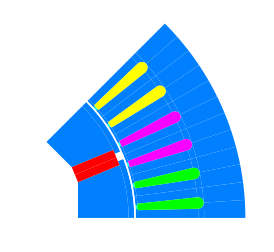

In [15]:
isa = femag.read_isa()
femagtools.plot.spel(isa)
plt.show()